**Author contact: Leslie Qiuchen Yang qy57@cornell.edu**

## Data

The dataset came from the edX course-Microsoft: DAT275x Principles of Machine Learning. In 1998, the Adventure Works Cycles company collected a large volume of data about their existing customers, including demographic features and information about purchases they have made. We are particularly interested in analyzing customer data to determine any apparent relationships between demographic features known about the customers and the likelihood of a customer purchasing a bike. 

## Algorithm

I will perform a widely used ensemble method known as **bootstrap aggregating** or simply **bagging**. Bagging follows a simple procedure:
1. N learners (machine learning models) are defined. 
2. N subsamples of the training data are created by **Bernoulli sampling with replacement**.
3. The N learners are trained on the subsamples of the training data.
4. The ensemble is scored by averaging, or taking a majority vote, of the predictions from the N learners.

**Classification models** are most typically used with bagging methods. The most common such algorithm is know as the **random forest**. The random forest method is highly scalable and generally produces good results, even for complex problems. By using random forest method, we are able to predict whether a customer will purchase the bike based on demographic features. 

## Application

**STEP 1** Import packages and datasets

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
#from statsmodels.api import datasets
from sklearn import datasets ## Get dataset from sklearn
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.random as nr

%matplotlib inline

spenddata = pd.read_csv('/Users/lesliesmac/Desktop/AW_AveMonthSpend.csv')
demodata = pd.read_csv('/Users/lesliesmac/Desktop/AdvWorksCusts.csv')
bikedata = pd.read_csv('/Users/lesliesmac/Desktop/AW_BikeBuyer.csv')

In [45]:
merge1 = pd.merge(spenddata, demodata, on='CustomerID')
now = pd.Timestamp(pd.datetime.now())
#create age variable from DOB as 'new_age'
merge1['BirthDate'] = pd.to_datetime(merge1['BirthDate'])
now = pd.datetime.now()    
merge1['age'] = (now - merge1['BirthDate'])/365
merge1['age'].head()
merge1['new_age']=merge1['age'].dt.days

**STEP 2** Create master dataset - merge2

In [162]:
merge2 = pd.merge(bikedata, merge1, on='CustomerID')
print(merge2.dtypes)
print('Shape of data:' +str(merge2.shape))

CustomerID                        int64
BikeBuyer                         int64
AveMonthSpend                     int64
Title                            object
FirstName                        object
MiddleName                       object
LastName                         object
Suffix                           object
AddressLine1                     object
AddressLine2                     object
City                             object
StateProvinceName                object
CountryRegionName                object
PostalCode                       object
PhoneNumber                      object
BirthDate                datetime64[ns]
Education                        object
Occupation                       object
Gender                           object
MaritalStatus                    object
HomeOwnerFlag                     int64
NumberCarsOwned                   int64
NumberChildrenAtHome              int64
TotalChildren                     int64
YearlyIncome                      int64


**STEP 3** Plot numerical features.

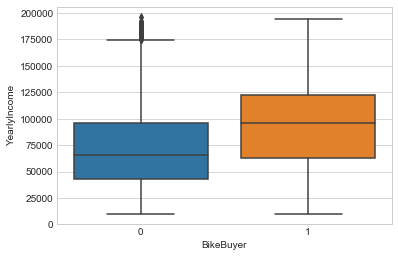

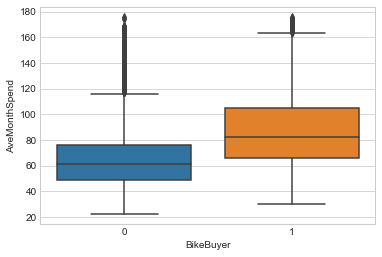

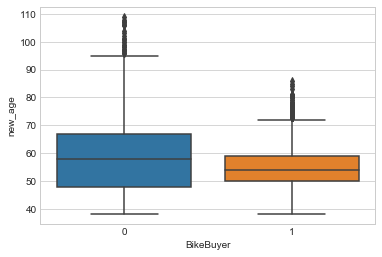

In [167]:
def plot_box(merge2, cols, col_x = 'BikeBuyer'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(x=col_x, y=col, data=merge2)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ['YearlyIncome','AveMonthSpend','new_age']
plot_box(merge2, num_cols, col_x = 'BikeBuyer')


Transfer categorical variables into dummy variables.

In [220]:
df_2 = pd.get_dummies(merge2,drop_first=True)

Features = np.array(df_2[['YearlyIncome','Gender_M','MaritalStatus_S','new_age','AveMonthSpend']])
Labels = np.array(df_2[['BikeBuyer']])

**STEP 4** Bagging

In [221]:
## Randomly sample cases to create independent training and test data
nr.seed(190)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 10000)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])#return 1D array
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

**STEP 5** Transform features into a Z-score scale

In [222]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**STEP 6** Define and fit a random forest model. The code in the cell below defines random forest model with 5 trees using the `RandomForestClassifer` function from the Scikit Learn ensemble  package, and then fits the model.

In [223]:
nr.seed(444)
rf_clf = RandomForestClassifier(n_estimators=5)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**STEP 7** 
Next, the code in the cell below performs the following processing to score the test data subset:
1. The test features are scaled using the scaler computed for the training features. 
2. The `predict` method is used to compute the scores from the scaled features. 

In [224]:
X_test = scale.transform(X_test)
scores = rf_clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**STEP 8** Evaluate the model results. 

Two label categories: Bike Buyer and NotBuy. Find the Accuracy, Precision and Recall for the model.

In [225]:
def print_metrics_3(labels, scores):
   
    conf = sklm.confusion_matrix(labels, scores)
    print('                    Confusion matrix')
    print('                 Score Buy   Score NotBuy')
    print('Actual Buy     %6d' % conf[0,0] + '        %5d' % conf[0,1] )
    print('Actual NotBuy  %6d' % conf[1,0] + '        %5d' % conf[1,1] )
    ## Now compute and display the accuracy and metrics
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    metrics = sklm.precision_recall_fscore_support(labels, scores)
   
    print(' ')
    print('                 Buy          NotBuy  ')
    print('Num case      %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1]  )
    print('Precision       %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1]  )
    print('Recall          %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1]  )
    print('F1              %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1]  )
    
print_metrics_3(y_test, scores)  


                    Confusion matrix
                 Score Buy   Score NotBuy
Actual Buy       5623         1115
Actual NotBuy    1282         1980

Accuracy        0.76
 
                 Buy          NotBuy  
Num case      6738.00       3262.00
Precision       0.81          0.64
Recall          0.83          0.61
F1              0.82          0.62


## Summary

The Machine learning model achieved 76% of accuracy in predicting customer purchasing. By looking at the Buyer cases vs NotBuy cases, we find a much higher accuracy in Buyer cases - since we are using more Buyer cases in training, the model assigned more weight in predicting Buyer cases. To adjust this, we need to include weight so that we can underweight the Buyer cases and overweight the NotBuy case to achieve better performance.